In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

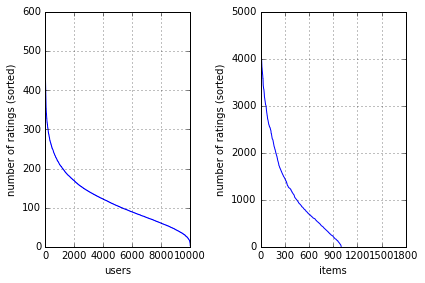

min # of items per user = 3, min # of users per item = 8.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    
    # build rating matrix.
    rows, cols = ratings.get_shape()

    
    train = sp.lil_matrix((rows, cols))
    test = sp.lil_matrix((rows, cols))
    
    print(rows, cols)
    
    nz_row, nz_col = valid_ratings.nonzero()
    print(len(nz_col))
    print(len(nz_row))
    for i in range(0, len(nz_col)):
        rand = np.random.random()
        if rand > p_test:
            train[nz_row[i],nz_col[i]] = valid_ratings[nz_row[i],nz_col[i]]
        else:
            test[nz_row[i],nz_col[i]] = valid_ratings[nz_row[i],nz_col[i]]
               
    print("Total number of nonzero elements in original data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)

1000 10000
1176873
1176873
Total number of nonzero elements in original data:1176873
Total number of nonzero elements in train data:1058916
Total number of nonzero elements in test data:117957


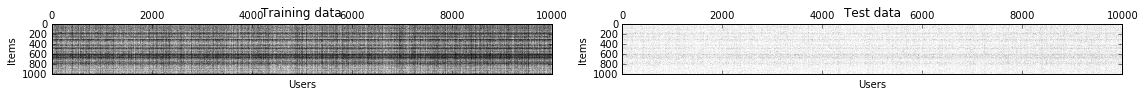

In [7]:
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [17]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    train_mean = train[train.nonzero()].mean()
    test_mean = test[test.nonzero()].mean()
    
    return train_mean, test_mean

mean = baseline_global_mean(train, test)
pred = np.ones(train.shape) * mean[0]
nz = valid_ratings.nonzero()
diff = valid_ratings[nz] - pred[nz]
rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
rmse

0.62613892970298168

### Use the user means as the prediction

In [39]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    train_means = train.sum(axis = 0) / (train.getnnz(axis=0)+1e-12)
    test_means = test.sum(axis = 0) / (test.getnnz(axis=0)+1e-12)
    
    return train_means, test_means

mean = baseline_user_mean(train, test)
print(mean[0].shape)
means = mean[0].tolist()
print(train.shape)
pred = np.ones(train.shape)
for col in range(train.shape[1]):
    pred[:,col] *= means[0][col]
nz = valid_ratings.nonzero()
diff = valid_ratings[nz] - pred[nz]
rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
rmse

(1, 10000)
(1000, 10000)


0.58920020083845515

### Use the item means as the prediction

In [72]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    train_means = train.sum(axis = 1) / (train.getnnz(axis=1)+1e-12).reshape(num_items, 1)
    test_means = test.sum(axis = 1) / (test.getnnz(axis=1)+1e-12).reshape(num_items, 1)
    
    return train_means, test_means
    
mean = baseline_item_mean(train, test)
print(mean[0].shape)
means = mean[0].tolist()
print(len(means))
print(train.shape)
pred = np.ones(train.shape)
for col in range(train.shape[0]):
    pred[col,:] *= means[col]
nz = valid_ratings.nonzero()
diff = valid_ratings[nz] - pred[nz]
rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
print(rmse)

exportSubmission("data/submission_item_mean.csv", pred)

(1000, 1)
1000
(1000, 10000)
0.52991473633
number of items: 1000, number of users: 10000


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [68]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    mean = baseline_global_mean(train, train)[0]
    num_items, num_users = train.shape
    user_features = np.ones((num_users, num_features))/np.sqrt(num_features/mean)
    item_features = np.ones((num_items, num_features))/np.sqrt(num_features/mean)
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [69]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    pred = item_features @ user_features.T
    diff = data[nz] - pred[nz]
    rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
    
    return rmse

user_features, item_features = init_MF(train, 20)
compute_error(train, user_features, item_features, train.nonzero())
train.nonzero()

(array([  0,   0,   0, ..., 998, 998, 998], dtype=int32),
 array([  43,   60,   66, ..., 9979, 9981, 9986], dtype=int32))

In [72]:
from plots import visualization

def matrix_factorization_SGD(train, test, num_epochs=50, num_features=20):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.0005
    lambda_user = 0.1
    lambda_item = 0.7
    errors = []
    errors_test = []
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    

    rmse = compute_error(train, user_features, item_features, train.nonzero())

    print("iter: k = {}, RMSE on training set: {}.".format(num_features, rmse))

    print("learn the matrix factorization using SGD...")
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1
        
        mult = item_features @ user_features.T
        item_grad = np.zeros(item_features.shape)
        user_grad = np.zeros(user_features.shape)
        nb = int(len(nz_train)/(5+np.sqrt(it)))
        for d, n in nz_train[:nb]:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
            pred_error = train[d, n] - mult[d, n]
            item_grad[d,:] += pred_error * user_features[n,:] * gamma
            user_grad[n,:] += pred_error * item_features[d,:] * gamma
        
        item_features += item_grad
        user_features += user_grad
        
        rmse = compute_error(train, user_features, item_features, train.nonzero())
        #print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        errors.append(rmse)
        
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        rmse = compute_error(test, user_features, item_features, test.nonzero())
        #print("iter: {}, RMSE on test set: {}.".format(it, rmse))
        errors_test.append(rmse)
        
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    print(len(errors))
    print(len(errors_test))
    print(np.linspace(1,num_epochs,num_epochs))
    visualization(np.linspace(1,num_epochs,num_epochs),errors,errors_test)
    
    return user_features, item_features


iter: k = 20, RMSE on training set: 0.6265586460250628.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 0.5599372440649816.
iter: 1, RMSE on training set: 0.5427523617970615.
iter: 2, RMSE on training set: 0.5345378978416625.
iter: 3, RMSE on training set: 0.529143097628302.
iter: 4, RMSE on training set: 0.5250292384991985.
iter: 5, RMSE on training set: 0.5218404247940944.
iter: 6, RMSE on training set: 0.5192292399016657.
iter: 7, RMSE on training set: 0.5169880912397752.
iter: 8, RMSE on training set: 0.5151371051724147.
iter: 9, RMSE on training set: 0.5134680664026061.
iter: 10, RMSE on training set: 0.5121126038969999.
iter: 11, RMSE on training set: 0.5108380476422473.
iter: 12, RMSE on training set: 0.5096638122100461.
iter: 13, RMSE on training set: 0.5086662819679025.
iter: 14, RMSE on training set: 0.5076708364357114.
iter: 15, RMSE on training set: 0.5068477167670337.
iter: 16, RMSE on training set: 0.5061188412872584.
iter: 17, RMSE on training 

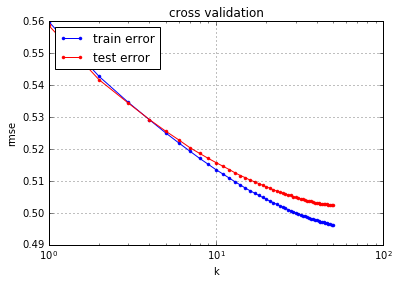

In [73]:
user_features, item_features = matrix_factorization_SGD(train, test)

In [74]:
compute_error(valid_ratings, user_features, item_features, valid_ratings.nonzero())

0.49668851942018671

In [77]:
pred =  (item_features @ user_features.T)
exportSubmission("data/submission_MF.csv", pred)

number of items: 1000, number of users: 10000


number of items: 1000, number of users: 10000


iter: -1, RMSE on training set: 7.68427824303344.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 3.9942719057599634.
iter: 1, RMSE on training set: 4.493371187682231.
iter: 2, RMSE on training set: 11.508095447955531.
iter: 3, RMSE on training set: 7.429045986922025.
iter: 4, RMSE on training set: 6.127945928419905.
iter: 5, RMSE on training set: 3.805646746236545.
iter: 6, RMSE on training set: 1.863702973354455.
iter: 7, RMSE on training set: 1.1299373300717424.
iter: 8, RMSE on training set: 0.8685474577104366.
iter: 9, RMSE on training set: 0.7530792698316878.
iter: 10, RMSE on training set: 0.6917579250267979.
iter: 11, RMSE on training set: 0.6554474951427223.
iter: 12, RMSE on training set: 0.6318832431267021.
iter: 13, RMSE on training set: 0.6158405206238255.
iter: 14, RMSE on training set: 0.60435007071753.
15
15
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.]
iter: -1, RMSE on training set: 7.747034664065258.
learn the

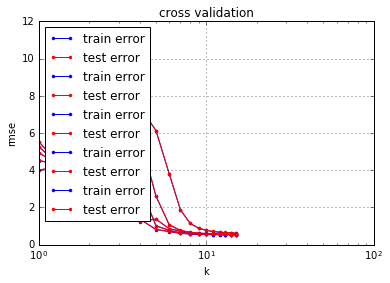

In [109]:
errors = []
for i in np.arange(10, 20, 2):
    user_features, item_features = matrix_factorization_SGD(train, test, num_epochs = 15, num_features = i)
    error = compute_error(valid_ratings, user_features, item_features, valid_ratings.nonzero())
    errors.append(error)


In [ ]:
visualization(np.arange(2, 20, 2),errors,errors)

In [76]:
import csv
import sys
def exportSubmission(path, pred):
    path_dataset = "data/sampleSubmission.csv"
    submission_ratings = load_data(path_dataset)
    submission_ratings.shape
    nz_row, nz_col = submission_ratings.nonzero()
    for i in range(0, len(nz_col)):
        submission_ratings[nz_row[i],nz_col[i]] = pred[nz_row[i],nz_col[i]]

    f = open(path, 'wt')
    try:
        writer = csv.writer(f)
        writer.writerow( ('Id', 'Prediction') )
        for i in range(0, len(nz_col)):
            ide = "r" + str(nz_col[i]+1) + "_c" + str(nz_row[i]+1)
            writer.writerow((ide, int(submission_ratings[nz_row[i],nz_col[i]] + 0.5)))
    finally:
        f.close()

### Learn the Matrix Factorization using Alternating Least Squares

In [12]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)